In [1]:
# clone the ADIS repository
!git clone https://github.com/sathishkumar67/SSD_MobileNetV3_ADIS.git
# move the files to the current directory
!mv /kaggle/working/SSD_MobileNetV3_ADIS/* /kaggle/working/
# upgrade pip
!pip install --upgrade pip
# install the required packages
!pip install  -r requirements.txt --upgrade --upgrade-strategy eager
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Cloning into 'SSD_MobileNetV3_ADIS'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 223 (delta 5), reused 16 (delta 5), pack-reused 206 (from 1)
Receiving objects: 100% (223/223), 49.90 MiB | 34.11 MiB/s, done.
Resolving deltas: 100% (131/131), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 138.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# necessary imports
import os
import optuna
import joblib
from typing import Tuple
from tqdm import tqdm
from ssd_mobnetv3_adis import unzip_file
from huggingface_hub import hf_hub_download
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler
from torchmetrics.detection import MeanAveragePrecision
from ssd_mobnetv3_adis import collate_fn, SSDLITEOBJDET_DATASET, CachedSSDLITEOBJDET_DATASET, SSD_MOBILENET_V3_Large

In [3]:
# set constants
REPO_ID = "pt-sk/ADIS" 
DATASET_NAME = "balanced_dataset"
REPO_TYPE = "dataset"
FILENAME_IN_REPO = f"{DATASET_NAME}.zip"
LOCAL_DIR = os.getcwd()
DATASET_PATH = f"{LOCAL_DIR}/{FILENAME_IN_REPO}"
DATASET_FOLDER_PATH = f"{LOCAL_DIR}/{DATASET_NAME}"                       
CLASSES = ['Cat', 'Cattle', 'Chicken', 'Deer', 'Dog', 'Squirrel', 'Eagle', 'Goat', 'Rodents', 'Snake'] 
NUM_CLASSES = len(CLASSES)
MODEL_NUM_CLASSES = NUM_CLASSES + 1    # 1 for background class

# download the dataset and unzip it
hf_hub_download(repo_id=REPO_ID, filename=FILENAME_IN_REPO, repo_type=REPO_TYPE, local_dir=LOCAL_DIR)
unzip_file(DATASET_PATH, LOCAL_DIR)

# number of cores
num_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cores}")

balanced_dataset.zip:   0%|          | 0.00/7.04G [00:00<?, ?B/s]

Unzipping: 100%|██████████| 7.07G/7.07G [00:41<00:00, 169MB/s]


Unzipped /kaggle/working/balanced_dataset.zip to /kaggle/working
Removed zip file: /kaggle/working/balanced_dataset.zip
Number of CPU cores: 4


In [4]:
# set pin memory device
PIN_MEMORY_DEVICE = "cuda:0"

# prepare the dataset
train_dataset = CachedSSDLITEOBJDET_DATASET(
    dataset_class=SSDLITEOBJDET_DATASET,
    root_dir=DATASET_FOLDER_PATH,
    split="train",
    num_classes=MODEL_NUM_CLASSES)

val_dataset = CachedSSDLITEOBJDET_DATASET(
    dataset_class=SSDLITEOBJDET_DATASET,
    root_dir=DATASET_FOLDER_PATH,
    split="val",
    num_classes=MODEL_NUM_CLASSES)

test_dataset = CachedSSDLITEOBJDET_DATASET(
    dataset_class=SSDLITEOBJDET_DATASET,
    root_dir=DATASET_FOLDER_PATH,
    split="test",
    num_classes=MODEL_NUM_CLASSES)


# samplers for reproducibility
train_sampler = RandomSampler(train_dataset, generator=torch.Generator().manual_seed(42))
val_sampler = RandomSampler(val_dataset, generator=torch.Generator().manual_seed(42))
test_sampler = RandomSampler(test_dataset, generator=torch.Generator().manual_seed(42))


# prepare the dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    sampler=train_sampler,
    num_workers=num_cores,
    collate_fn=collate_fn,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    pin_memory_device=PIN_MEMORY_DEVICE)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    sampler=val_sampler,
    num_workers=num_cores,
    collate_fn=collate_fn,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    pin_memory_device=PIN_MEMORY_DEVICE)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    sampler=test_sampler,
    num_workers=num_cores,
    collate_fn=collate_fn,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    pin_memory_device=PIN_MEMORY_DEVICE)

Preprocessing dataset and caching to /kaggle/working/balanced_dataset/train_cache...


100%|██████████| 18139/18139 [03:37<00:00, 83.48it/s] 


Preprocessing dataset and caching to /kaggle/working/balanced_dataset/val_cache...


100%|██████████| 2390/2390 [00:26<00:00, 89.87it/s] 


Preprocessing dataset and caching to /kaggle/working/balanced_dataset/test_cache...


100%|██████████| 2390/2390 [00:28<00:00, 85.16it/s] 


In [ ]:
ssdlite_mobnet_v3_tuned
ssdlite_mobnet_v3_no_tune

In [16]:
model = SSD_MOBILENET_V3_Large(num_classes_with_bg=MODEL_NUM_CLASSES)
model.load_state_dict(torch.load("/kaggle/working/ssdlite_mobnet_v3_no_tune.pth", map_location="cpu")["model_state_dict"], strict=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model loaded to device: {device}")

Model loaded to device: cuda


In [17]:
import torch
import pandas as pd
from tqdm import tqdm
from torchmetrics.detection import MeanAveragePrecision
from torchvision.ops import box_iou
from collections import defaultdict


def evaluate_model(model, dataloader, device, iou_threshold=0.5):
    metric = MeanAveragePrecision(
        box_format='xyxy',
        iou_type='bbox',
        iou_thresholds=[iou_threshold],
        class_metrics=True,
        extended_summary=True
    )
    
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            # Move images to the device
            outputs = model(images.to(device))
            
            # Convert outputs to TorchMetrics format
            preds = []
            for i, output in enumerate(outputs):
                preds.append({
                    'boxes': output['boxes'].cpu(),
                    'scores': output['scores'].cpu(),
                    'labels': output['labels'].cpu()
                })
            
            # Convert targets to TorchMetrics format
            targs = []
            for target in targets:
                targs.append({
                    'boxes': target['boxes'].cpu(),
                    'labels': target['labels'].cpu()
                })
            
            metric.update(preds, targs)
    
    # Compute metrics
    results = metric.compute()
    return results

In [18]:
def calculate_per_class_with_iou(model, dataloader, device, classes,
                                conf_thresh=0.2, iou_thresh=0.5):
    counters  = defaultdict(lambda: {"tp":0,"fp":0,"fn":0,"support":0})
    iou_sums   = defaultdict(float)
    iou_counts = defaultdict(int)

    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            outputs = model([img.to(device) for img in images])
            for output, target in zip(outputs, targets):
                # Prepare tensors
                pred_boxes  = output["boxes"].cpu()
                pred_scores = output["scores"].cpu()
                pred_labels = output["labels"].cpu()
                true_boxes  = target["boxes"]
                true_labels = target["labels"]

                # Filter by confidence
                keep = pred_scores > conf_thresh
                pred_boxes  = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                # Count support
                for lbl in true_labels.tolist():
                    counters[lbl]["support"] += 1

                # No predictions → all GT are FN
                if pred_boxes.numel() == 0:
                    for lbl in true_labels.tolist():
                        counters[lbl]["fn"] += 1
                    continue

                # Compute IoU matrix and find matches
                iou_matrix = box_iou(pred_boxes, true_boxes)
                matches    = torch.nonzero(iou_matrix > iou_thresh, as_tuple=False)

                matched_pred, matched_true = set(), set()
                for pi, ti in matches.tolist():
                    matched_pred.add(pi); matched_true.add(ti)
                    p_lbl = int(pred_labels[pi].item())
                    t_lbl = int(true_labels[ti].item())

                    if p_lbl == t_lbl:
                        counters[p_lbl]["tp"] += 1
                        iou_sums[p_lbl]   += iou_matrix[pi, ti].item()
                        iou_counts[p_lbl] += 1
                    else:
                        counters[p_lbl]["fp"] += 1
                        counters[t_lbl]["fn"] += 1

                # Unmatched → FP or FN
                for pi in range(len(pred_boxes)):
                    if pi not in matched_pred:
                        cls = int(pred_labels[pi].item())
                        counters[cls]["fp"] += 1
                for ti in range(len(true_boxes)):
                    if ti not in matched_true:
                        cls = int(true_labels[ti].item())
                        counters[cls]["fn"] += 1

    # Build results
    results = {}
    for cls, cnt in counters.items():
        tp, fp, fn, sup = cnt["tp"], cnt["fp"], cnt["fn"], cnt["support"]
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1   = 2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0.0
        avg_iou = iou_sums[cls]/iou_counts[cls] if iou_counts[cls]>0 else 0.0
        accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0
        
        # Store results
        results[cls] = {
            "count": sup,
            "precision": prec,
            "recall":    rec,
            "f1_score":  f1,
            "accuracy":  accuracy,
            "avg_iou":   avg_iou
        }
        
    # Convert to DataFrame for better readability
    df_metrics = pd.DataFrame(results).T
    df_metrics.index = [classes[idx-1] for idx in df_metrics.index]
    df_metrics = df_metrics.sort_index()
    map_score =  evaluate_model(model, dataloader, device)["map_per_class"].cpu().tolist()
    df_metrics["mAP"] = map_score
    return df_metrics

In [21]:
import time
start_time = time.time()
df_metrics = calculate_per_class_with_iou(model, test_loader, device, classes=CLASSES)
df_metrics.loc["Average"] = df_metrics.mean()
print(f"Per-class metrics for train set:\n{df_metrics}")
end_time = time.time()
print(f"Time taken for set evaluation: {end_time - start_time:.2f} seconds")

Per-class metrics for train set:
          count  precision    recall  f1_score  accuracy   avg_iou       mAP
Cat       242.0   0.807971  0.835206  0.821363  0.696875  0.851417  0.926831
Cattle    345.0   0.615385  0.702842  0.656212  0.488330  0.816393  0.749127
Chicken   562.0   0.593007  0.690554  0.638074  0.468508  0.769573  0.660554
Deer      357.0   0.721448  0.636364  0.676240  0.510848  0.830083  0.713557
Dog       293.0   0.782759  0.652299  0.711599  0.552311  0.790232  0.794361
Eagle     265.0   0.762712  0.778547  0.770548  0.626741  0.866089  0.784616
Goat      340.0   0.540000  0.626289  0.579952  0.408403  0.816291  0.860419
Rodents   280.0   0.583756  0.694864  0.634483  0.464646  0.811975  0.652390
Snake     252.0   0.708738  0.832700  0.765734  0.620397  0.773342  0.744437
Squirrel  245.0   0.623145  0.675241  0.648148  0.479452  0.793225  0.829231
Average   318.1   0.673892  0.712490  0.690235  0.531651  0.811862  0.771552
Time taken for set evaluation: 49.62 second

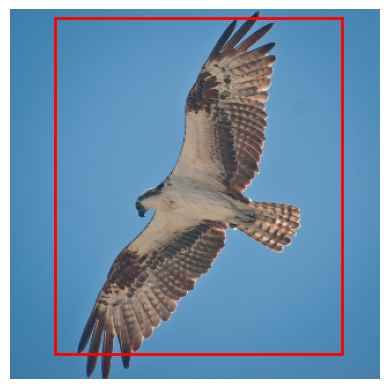

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# plt.imshow(images[2].cpu().permute(1, 2, 0).int().numpy())
# # plot the bounding boxes
# x1, y1, x2, y2 = box
# width = x2 - x1
# height = y2 - y1
# rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
# plt.gca().add_patch(rect)
# # axis off
# plt.axis('off')
# plt.show()

In [ ]:
# box = output1["boxes"][0].cpu().numpy()
# box

array([ 38.8498   ,   6.8742523, 286.90234  , 298.28052  ], dtype=float32)

In [ ]:
# output1["scores"], output1["scores"].shape, output1["scores"].argmax()

(tensor([0.2950, 0.1710, 0.1168, 0.1146, 0.1058, 0.0868, 0.0788, 0.0728, 0.0717,
         0.0698, 0.0689, 0.0686, 0.0685, 0.0680, 0.0660, 0.0654, 0.0645, 0.0644,
         0.0640, 0.0638, 0.0636, 0.0629, 0.0628, 0.0621, 0.0612, 0.0610, 0.0609,
         0.0607, 0.0599, 0.0597, 0.0596, 0.0596, 0.0592, 0.0591, 0.0585, 0.0584,
         0.0583, 0.0582, 0.0582, 0.0582, 0.0581, 0.0579, 0.0579, 0.0578, 0.0577,
         0.0575, 0.0574, 0.0572, 0.0570, 0.0569, 0.0563, 0.0563, 0.0559, 0.0551,
         0.0550, 0.0548, 0.0544, 0.0544, 0.0543, 0.0542, 0.0539, 0.0539, 0.0536,
         0.0536, 0.0536, 0.0535, 0.0534, 0.0532, 0.0529, 0.0529, 0.0527, 0.0526,
         0.0525, 0.0524, 0.0523, 0.0522, 0.0521, 0.0520, 0.0520, 0.0519, 0.0517,
         0.0510, 0.0510, 0.0509, 0.0509, 0.0508, 0.0507, 0.0506, 0.0505, 0.0504,
         0.0504, 0.0503, 0.0502, 0.0501, 0.0501, 0.0500, 0.0499, 0.0498, 0.0497,
         0.0497], device='cuda:0'),
 torch.Size([100]),
 tensor(0, device='cuda:0'))

In [ ]:
# output1.keys()

dict_keys(['boxes', 'scores', 'labels'])

In [ ]:
# progress_bar = tqdm(val_loader, desc="Evaluating", unit="batch", total=len(val_loader))
# model.eval()
# with torch.no_grad():
#     for images, targets in progress_bar:
#         images = images.to(device)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         predictions = model(images)
#         metric.update(predictions, targets)
#     map_results = metric.compute()

Evaluating: 100%|██████████| 19/19 [00:18<00:00,  1.03batch/s]


In [ ]:
# def calculate_detection_accuracy(model, dataloader, device, iou_threshold=0.5):
#     model.eval()
#     true_positives = 0
#     false_positives = 0
#     false_negatives = 0
    
#     with torch.no_grad():
#         for images, targets in dataloader:
#             outputs = model(images.to(device))
            
#             for output, target in zip(outputs, targets):
#                 # Convert to CPU tensors
#                 pred_boxes = output['boxes'].cpu()
#                 pred_labels = output['labels'].cpu()
#                 pred_scores = output['scores'].cpu()
#                 true_boxes = target['boxes'].cpu()
#                 true_labels = target['labels'].cpu()
                
#                 # Initialize matches
#                 true_matched = torch.zeros(true_boxes.shape[0], dtype=torch.bool)
#                 pred_matched = torch.zeros(pred_boxes.shape[0], dtype=torch.bool)
                
#                 # Calculate IoU matrix
#                 iou_matrix = box_iou(pred_boxes, true_boxes)
                
#                 # Match predictions to ground truth
#                 for pred_idx in range(pred_boxes.shape[0]):
#                     # Find best matching ground truth
#                     iou_values = iou_matrix[pred_idx]
#                     best_iou, best_gt_idx = iou_values.max(dim=0)
                    
#                     if best_iou >= iou_threshold and not true_matched[best_gt_idx]:
#                         # Check class match
#                         if pred_labels[pred_idx] == true_labels[best_gt_idx]:
#                             true_positives += 1
#                             true_matched[best_gt_idx] = True
#                             pred_matched[pred_idx] = True
                
#                 # Count remaining unmatched predictions as FP
#                 false_positives += (pred_matched == False).sum().item()
                
#                 # Count remaining unmatched ground truth as FN
#                 false_negatives += (true_matched == False).sum().item()
    
#     # Calculate accuracy metrics
#     precision = true_positives / (true_positives + false_positives + 1e-6)
#     recall = true_positives / (true_positives + false_negatives + 1e-6)
#     f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
#     detection_accuracy = true_positives / (true_positives + false_positives + false_negatives + 1e-6)
    
#     print(f"Detection Accuracy: {detection_accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1 Score: {f1_score:.4f}")
#     print(f"True Positives: {true_positives}")
#     print(f"False Positives: {false_positives}")
#     print(f"False Negatives: {false_negatives}")
    
#     return {
#         'accuracy': detection_accuracy,
#         'precision': precision,
#         'recall': recall,
#         'f1': f1_score,
#         'TP': true_positives,
#         'FP': false_positives,
#         'FN': false_negatives
#     }
    
# results = calculate_detection_accuracy(
#     model=model,
#     dataloader=test_loader,  # Your test dataloader
#     device="cuda:0"
# )

Detection Accuracy: 0.0123
Precision: 0.0123
Recall: 0.9249
F1 Score: 0.0243
True Positives: 2942
False Positives: 236058
False Negatives: 239


In [ ]:
# def train(warmup_epochs: int, num_epochs: int, patience: int, initial_lr: float, betas: Tuple[float, float], weight_decay: float, dataloaders: dict[str, torch.utils.data.DataLoader]) -> None:
#     # early stopping parameters
#     best_map = float('-inf')
#     patience_counter = 0
    
#     # get the dataloaders
#     train_loader, val_loader = dataloaders['train'], dataloaders['val']
    
#     # Set device
#     device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#     print(f"Using device: {device}")
    
#     # Load the model
#     model = SSD_MOBILENET_V3_Large(num_classes_with_bg=MODEL_NUM_CLASSES)
#     model.to(device)
    
#     # Optimizer
#     optimizer = model.configure_optimizers(lr=initial_lr, betas=betas, weight_decay=weight_decay, eps=1e-08, fused=True)
    
#     for epoch in range(num_epochs):
#         # Warmup phase: linearly increase learning rate for the first 4 epochs
#         if epoch < warmup_epochs:
#             lr = initial_lr * (epoch + 1) / warmup_epochs
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr
#         # Training phase
#         model.train()
#         total_loss = 0.0
#         num_batches = len(train_loader)
        
#         # Progress bar
#         train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        
#         for _, (images, targets) in enumerate(train_bar):
#             # Move data to device
#             images = images.to(device)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#             # Forward pass
#             loss_dict = model(images, targets)
#             losses = sum(loss for loss in loss_dict.values())
            
#             # Backward pass and optimization
#             optimizer.zero_grad()
#             losses.backward()
#             optimizer.step()
            
#             batch_loss = losses.detach().item()
#             total_loss += batch_loss
            
#             # Update progress bar
#             train_bar.set_postfix(loss=batch_loss)
        
#         avg_loss = total_loss / num_batches
#         print(f"Epoch {epoch+1}/{num_epochs} | Learning Rate: {lr:.6f} | Avg Train Loss: {avg_loss:.4f}")
        
#         # Validation phase
#         model.eval()
#         metric = MeanAveragePrecision()
#         eval_bar = tqdm(val_loader, desc=f"Validating...", unit="batch")
#         with torch.no_grad():
#             for images, targets in eval_bar:
#                 # Move data to device
#                 images = images.to(device)
#                 targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#                 # Forward pass    
#                 predictions = model(images)
#                 metric.update(predictions, targets)
        
#         map_result = metric.compute()
#         print(f"Epoch {epoch+1} | Val mAP: {map_result['map']:.4f}")
        
#         # Early stopping logic
#         if map_result['map'] > best_map:
#             best_map = map_result['map']
#             best_model_state_dict = {k: v.cpu() for k, v in model.state_dict().items()} 
#             best_optimizer_state_dict = optimizer.state_dict()
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print("Early stopping triggered at epoch", epoch + 1)
#                 # save the best model
#                 torch.save({"model_state_dict" : best_model_state_dict,
#                     "optimizer_state_dict" : best_optimizer_state_dict,
#                 }, f"{LOCAL_DIR}/best_model.pth")
#                 print(f"Best model saved with mAP: {best_map:.4f}")
#                 break

# # train the model with the suggested hyperparameters
# train(warmup_epochs=4, num_epochs=50, patience=5, initial_lr=0.0001, betas=(0.9, 0.999), weight_decay=0.001, dataloaders={'train': train_loader, 'val': val_loader})

In [ ]:
# # bohb tuning parameters
# def train(warmup_epochs: int, num_epochs: int, patience: int, initial_lr: float, betas: Tuple[float, float], weight_decay: float, dataloaders: dict[str, torch.utils.data.DataLoader], callback):
#     # early stopping parameters
#     best_map = float('-inf')
#     patience_counter = 0
    
#     # get the dataloaders
#     train_loader, val_loader = dataloaders['train'], dataloaders['val']
    
#     # Set device
#     device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#     print(f"Using device: {device}")
    
#     # Load the model
#     model = SSD_MOBILENET_V3_Large(num_classes_with_bg=MODEL_NUM_CLASSES)
#     model.to(device)
    
#     # Optimizer
#     optimizer = model.configure_optimizers(lr=initial_lr, betas=betas, weight_decay=weight_decay, eps=1e-08, fused=True)
    
#     for epoch in range(num_epochs):
#         # Warmup phase: linearly increase learning rate for the first 4 epochs
#         if epoch < warmup_epochs:
#             lr = initial_lr * (epoch + 1) / warmup_epochs
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr
#         # Training phase
#         model.train()
#         total_loss = 0.0
#         num_batches = len(train_loader)
        
#         # Progress bar
#         train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        
#         for _, (images, targets) in enumerate(train_bar):
#             # Move data to device
#             images = images.to(device)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#             # Forward pass
#             loss_dict = model(images, targets)
#             losses = sum(loss for loss in loss_dict.values())
            
#             # Backward pass and optimization
#             optimizer.zero_grad()
#             losses.backward()
#             optimizer.step()
            
#             batch_loss = losses.detach().item()
#             total_loss += batch_loss
            
#             # Update progress bar
#             train_bar.set_postfix(loss=batch_loss)
        
#         avg_loss = total_loss / num_batches
#         print(f"Epoch {epoch+1}/{num_epochs} | Learning Rate: {lr:.6f} | Avg Train Loss: {avg_loss:.4f}")
        
#         # Validation phase
#         model.eval()
#         metric = MeanAveragePrecision()
#         eval_bar = tqdm(val_loader, desc=f"Validating...", unit="batch")
#         with torch.no_grad():
#             for images, targets in eval_bar:
#                 # Move data to device
#                 images = images.to(device)
#                 targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#                 # Forward pass    
#                 predictions = model(images)
#                 metric.update(predictions, targets)
        
#         map_result = metric.compute()
#         print(f"Epoch {epoch+1} | Val mAP: {map_result['map']:.4f}")
        
#         # Report the validation mAP
#         callback(map_result['map'], epoch+1)
        
#         # Early stopping logic
#         if map_result['map'] > best_map:
#             best_map = map_result['map']
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print("Early stopping triggered at epoch", epoch + 1)
#                 break
            
#     return best_map

In [ ]:
# # constants
# WARMUP_EPOCHS = 3
# NUM_EPOCHS = 15
# PATIENCE = 3

# # define the dataloaders
# dataloaders = {"train":train_loader, "val":val_loader}

# # define the objective function
# def objective(trial):
#     # define callback to report intermidiate results
#     def on_train_epoch_end(score, epoch):
#         trial.report(score, step=epoch)  
#         if trial.should_prune():
#             raise optuna.TrialPruned()
        
#     # suggest hyperparameters for the model
#     lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
#     weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
#     momentum = trial.suggest_float("momentum", 0.7, 0.99)
    
#     # train the model
#     best_map = train(warmup_epochs=WARMUP_EPOCHS, num_epochs=NUM_EPOCHS, patience=PATIENCE, initial_lr=lr, betas=(momentum, 0.999), weight_decay=weight_decay,
#         dataloaders=dataloaders, callback=on_train_epoch_end)
    
#     # return the best mAP
#     return best_map

In [ ]:
# # define the number of trials
# NUM_TRIALS = 5

# # load the study
# study = optuna.create_study(direction='maximize', 
#                             sampler=optuna.samplers.TPESampler(), 
#                             pruner=optuna.pruners.HyperbandPruner(),
#                             study_name="ssd_mobnetv3_adis_tuning",
#                             load_if_exists=True)

# # Optimize with a callback to stop after NUM_TRIALS complete trials
# study.optimize(objective, n_trials=NUM_TRIALS)

In [ ]:
# joblib.dump(study, f"{LOCAL_DIR}/optuna_study.pkl")